<a href="https://colab.research.google.com/github/egemengulpinar/Image-Super-Resolution-SRCNN-notes/blob/main/SRCNN_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import numpy as np
from torch.utils.data import Dataset


In [2]:
from torch import nn

class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x



In [3]:
##Utils
import torch
import numpy as np


def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))


def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
##Prepare
import argparse
import glob
import h5py
import numpy as np
import PIL.Image as pil_image



h5_file = h5py.File('/content/drive/MyDrive/SRCNN_Files/new_deneme_x2.h5', 'w')

lr_group = h5_file.create_group('lr')
hr_group = h5_file.create_group('hr')
scale = 3
for i, image_path in enumerate(sorted(glob.glob('{}/*'.format('/content/drive/MyDrive/SRCNN_Files/814A12F8-E160-4472-AB56-0A942BD6B91B.jpeg')))):
    hr = pil_image.open(image_path).convert('RGB')
    print(i)
    hr_width = (hr.width // scale) * scale
    hr_height = (hr.height // scale) * scale
    hr = hr.resize((hr_width, hr_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
    lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    hr = np.array(hr).astype(np.float32)
    lr = np.array(lr).astype(np.float32)
    hr = convert_rgb_to_y(hr)
    lr = convert_rgb_to_y(lr)

    lr_group.create_dataset(str(i), data=lr)
    hr_group.create_dataset(str(i), data=hr)

h5_file.close()


In [5]:
##Dataset
class EvalDataset(Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][str(idx)][:, :] / 255., 0), np.expand_dims(f['hr'][str(idx)][:, :] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
##Eval
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)
from skimage.measure import compare_ssim
if scale == 2:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x2.pth"
if scale == 3:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x3.pth"
if scale == 4:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x4.pth"

# weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x4.pth"
state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()

eval_dataset = EvalDataset('/content/drive/MyDrive/SRCNN_Files/new_deneme_x2.h5')

eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)


# epoch_psnr = AverageMeter()
# epoch_ssim = AverageMeter()
# epoch_psnr_bicubic = AverageMeter()
# epoch_ssim_bicubic = AverageMeter()
# flag = 1
# for data in eval_dataloader:
#     inputs, labels = data

#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     with torch.no_grad():
#         preds = model(inputs).clamp(0.0, 1.0)

#     preds_ssim = np.array(np.squeeze(preds))
#     y_ssim = np.array(np.squeeze(labels))

#     inputs_ssim = np.array(np.squeeze(inputs))
#     epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

#     epoch_psnr_bicubic.update(calc_psnr(inputs, labels), len(inputs))

#     epoch_ssim.update(compare_ssim(preds_ssim, y_ssim), len(inputs))

#     epoch_ssim_bicubic.update(compare_ssim(inputs_ssim, y_ssim), len(inputs))
#     print(epoch_ssim.val)
#     # if flag == 20:
#     #   break
#     # else:
#     #   flag = flag + 1

# print('eval SRCNN psnr: {:.2f}'.format(epoch_psnr.avg))
# print('eval Bicubic psnr : {:.4f}'.format(epoch_psnr_bicubic.avg))
# print('eval SRCNN ssim: {:.2f}'.format(epoch_ssim.avg))
# print('eval Bicubic ssim: {:.4f}'.format(epoch_ssim_bicubic.avg))

In [ ]:
## Test Part
import argparse

import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image
from skimage.measure import compare_ssim
image_file_new = "/content/drive/MyDrive/SRCNN_Files/Tested_images"

if scale == 2:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x2.pth"
if scale == 3:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x3.pth"
if scale == 4:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x4.pth"




image_file = "/content/drive/MyDrive/SRCNN_Files/814A12F8-E160-4472-AB56-0A942BD6B91B.jpeg"
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SRCNN().to(device)

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()

image = pil_image.open(image_file).convert('RGB')
# print("input_image -->" , input_image)
# Main image in RBG color scale
print(image.getpixel)
input_image_png = image



image_width = (image.width // scale) * scale #for integer deviation
image_height = (image.height // scale) * scale

image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
# print(image.getpixel)

input_image = np.array(image).astype(np.float32)

ycbcr = convert_rgb_to_ycbcr(input_image)
# print("ycbcr--> ", ycbcr)
## converting to RGB --> to --> ycbcr color space. Because of, we can calculate more effectively in ycbcr color space than RGB.
print(ycbcr.shape)
y_input = ycbcr[..., 0]
# print("y_input after ycbcr[...,0] ----> ", y_input)
## in this part, we select ycbcr space 1 inputs --> [Y CB CR]--we select all Y channel inputs.
print(y_input.shape)
y_input /= 255.
 ## 0 and 1 values. NORMALIZATION.
y_input = torch.from_numpy(y_input).to(device)
# print(y_input)

image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
print(image.getpixel)
image = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
image.save(image_file_new + "/ORIGINAL_UPSCALE__bicubic_x{}.JPEG" .format(scale))
print(image.getpixel)

# image.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))
image.save(image_file_new + "/bicubic_x{}.JPEG" .format(scale))
bicubic_image_png = image



image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)

y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y).to(device)
y = y.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y).clamp(0.0, 1.0)


psnr_bicubic = calc_psnr(y_input, y)
print('Bicubic PSNR: {:.2f}'.format(psnr_bicubic))

preds_ssim_bicubic = np.array(np.squeeze(y))
y_ssim_bicubic = np.array(np.squeeze(y_input))
ssim_bicubic = compare_ssim(y_ssim_bicubic, preds_ssim_bicubic)
print('Bicubic SSIM: {:.2f}'.format(ssim_bicubic))

psnr_SRCNN = calc_psnr(y, preds)
print('SRCNN PSNR: {:.2f}'.format(psnr_SRCNN))

preds_ssim = np.array(np.squeeze(preds))
y_ssim = np.array(np.squeeze(y))
ssim_SRCNN =compare_ssim(y_ssim,preds_ssim)
print('SRCNN SSIM: {:.2f}'.format(ssim_SRCNN))
preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
output = pil_image.fromarray(output)
output.save(image_file_new + "/ORIGINAL_UPSCALE__srcnn_x_x{}.JPEG" .format(scale))
output.save(image_file_new + "/srcnn_x{}.JPEG" .format(scale))
# output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))
output_image_png = output


In [ ]:
## Test Part
import argparse

import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image
from skimage.measure import compare_ssim
image_file_new = "/content/drive/MyDrive/SRCNN_Files/Tested_images"

# scale = 4
if scale == 2:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x2.pth"
if scale == 3:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x3.pth"
if scale == 4:
  weights_file = "/content/drive/MyDrive/SRCNN_Files/srcnn_x4.pth"




image_file = "/content/drive/MyDrive/SRCNN_Files/yaprak.jpeg"
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SRCNN().to(device)

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()

image = pil_image.open(image_file).convert('RGB')
# print("input_image -->" , input_image)
# Main image in RBG color scale
print(image.getpixel)
input_image_png = image



image_width = (image.width // scale) * scale #for integer deviation
image_height = (image.height // scale) * scale

image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
# print(image.getpixel)

input_image = np.array(image).astype(np.float32)

ycbcr = convert_rgb_to_ycbcr(input_image)
# print("ycbcr--> ", ycbcr)
## converting to RGB --> to --> ycbcr color space. Because of, we can calculate more effectively in ycbcr color space than RGB.
print(ycbcr.shape)
y_input = ycbcr[..., 0]
# print("y_input after ycbcr[...,0] ----> ", y_input)
## in this part, we select ycbcr space 1 inputs --> [Y CB CR]--we select all Y channel inputs.
print(y_input.shape)
y_input /= 255.
 ## 0 and 1 values. NORMALIZATION.
y_input = torch.from_numpy(y_input).to(device)
# print(y_input)

# image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
# print(image.getpixel)
image = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
print(image.getpixel)

# image.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))
image.save(image_file_new + "/bicubic_x{}.JPEG" .format(scale))
bicubic_image_png = image



image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)

y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y).to(device)
y = y.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y).clamp(0.0, 1.0)


# psnr_bicubic = calc_psnr(y_input, y)
# print('Bicubic PSNR: {:.2f}'.format(psnr_bicubic))

preds_ssim_bicubic = np.array(np.squeeze(y))
y_ssim_bicubic = np.array(np.squeeze(y_input))
# ssim_bicubic = compare_ssim(y_ssim_bicubic, preds_ssim_bicubic)
# print('Bicubic SSIM: {:.2f}'.format(ssim_bicubic))

# psnr_SRCNN = calc_psnr(y, preds)
# print('SRCNN PSNR: {:.2f}'.format(psnr_SRCNN))

preds_ssim = np.array(np.squeeze(preds))
y_ssim = np.array(np.squeeze(y))
# ssim_SRCNN =compare_ssim(y_ssim,preds_ssim)
# print('SRCNN SSIM: {:.2f}'.format(ssim_SRCNN))
preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
output = pil_image.fromarray(output)

output.save(image_file_new + "/srcnn_x{}.JPEG" .format(scale))
# output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))
output_image_png = output


<bound method Image.getpixel of <PIL.Image.Image image mode=RGB size=765x1130 at 0x7F745B45EAD0>>
(1128, 765, 3)
(1128, 765)
<bound method Image.getpixel of <PIL.Image.Image image mode=RGB size=2295x3384 at 0x7F744BD2E510>>


In [ ]:

# print(ycbcr.shape)
# print(y_input.shape)
# new_array = d3 = np.array([[[np.random.random_integers(10) for col in range(4)]for row in range(4)] for x in range(6)])
# print(new_array)
# print(new_array.shape)
# new_array = new_array[...,0]
# print("new-->" ,new_array)
# print(new_array.shape)

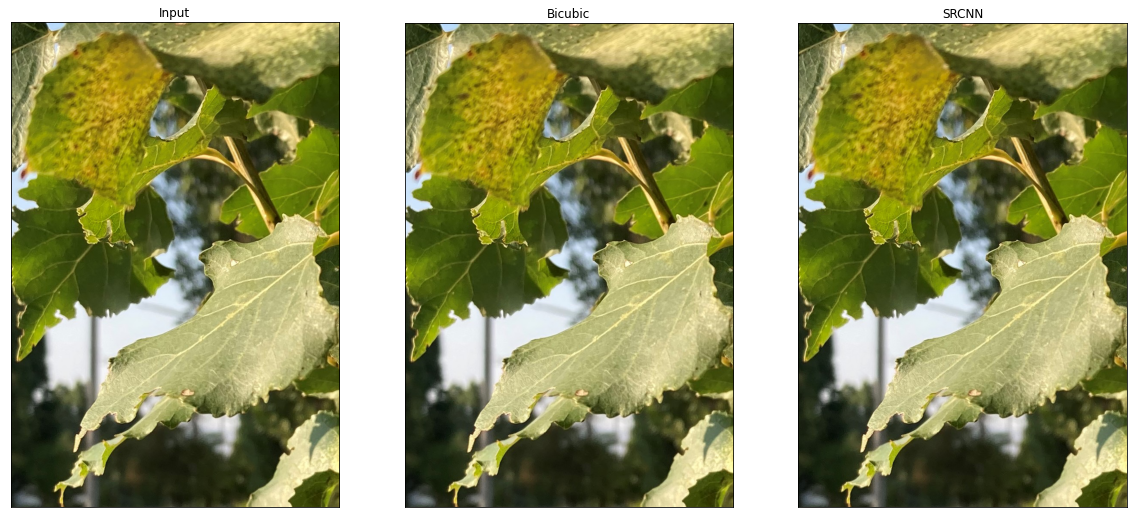

In [ ]:
# fig.add_subplot(rows, columns, 1)

from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(20, 10))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(input_image_png)
plt.title("Input")

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns,2)

# showing image
plt.imshow(bicubic_image_png)
plt.title("Bicubic")
# plt.xlabel("PSNR Score : {:.2f} " .format(psnr_bicubic) + "              SSIM Score : {:.4f} " .format(ssim_bicubic))


ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(output_image_png)

plt.title("SRCNN")
# plt.xlabel("PSNR Score : {:.2f} " .format(psnr_SRCNN) + "              SSIM Score : {:.4f} " .format(ssim_SRCNN))


ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()




